In [1]:
import cv2 
import torch.nn.functional as F
import torchvision
import torch
from torch import nn
import torchvision.transforms as T
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from pathlib import Path
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
IMAGE_EXTENTIONS = (".png", ".jpg", ".jpeg", ".tiff", ".bmp", ".gif")
import cv2 
from tqdm import tqdm
def resize(image,f=0.3):
    """Resize 'image' by 'f' in both dimensions."""
    newDim = (int(f*image.shape[0]),int(f*image.shape[1]))
    return cv2.resize(image, (newDim[1], newDim[0]), interpolation=cv2.INTER_CUBIC)


def resize_dir(path2dir, path2save, scale = 0.5):
    files = [x for x in Path(path2dir).rglob("*") if x.suffix in IMAGE_EXTENTIONS]
    for f in tqdm(files):
        try:
            img = cv2.imread(str(f))
            img = cv2.resize(img,(224,224))
            cv2.imwrite(str(path2save / f.name), img)
        except Exception as er:
            print(er)
            pass

In [ ]:
# resize_dir("/storage/reshetnikov/URFU/Computer-Vision-Course_lec-practice/data/animals/lion/", 
#            Path("/storage/reshetnikov/URFU/Computer-Vision-Course_lec-practice/data/animals/lion/"),
#            0.5)

In [96]:
p2root =  Path('/storage/reshetnikov/URFU/Computer-Vision-Course_lec-practice/data/animals/test/')
k = 31
for f in p2root.rglob("*"):
    # os.rename(f, f.parent / f'Lion_{k}.jpg')
    print(f)
    k+=1

/storage/reshetnikov/URFU/Computer-Vision-Course_lec-practice/data/animals/test/panda_76.jpg
/storage/reshetnikov/URFU/Computer-Vision-Course_lec-practice/data/animals/test/bear_183.jpg
/storage/reshetnikov/URFU/Computer-Vision-Course_lec-practice/data/animals/test/tiger_91.jpg
/storage/reshetnikov/URFU/Computer-Vision-Course_lec-practice/data/animals/test/elephant_22.jpg
/storage/reshetnikov/URFU/Computer-Vision-Course_lec-practice/data/animals/test/cat_293.jpg
/storage/reshetnikov/URFU/Computer-Vision-Course_lec-practice/data/animals/test/dolphin_154.jpg
/storage/reshetnikov/URFU/Computer-Vision-Course_lec-practice/data/animals/test/panda_3.jpg
/storage/reshetnikov/URFU/Computer-Vision-Course_lec-practice/data/animals/test/tiger_66.jpg
/storage/reshetnikov/URFU/Computer-Vision-Course_lec-practice/data/animals/test/elephant_224.jpg
/storage/reshetnikov/URFU/Computer-Vision-Course_lec-practice/data/animals/test/horse_3.jpg
/storage/reshetnikov/URFU/Computer-Vision-Course_lec-practice/d

In [219]:
# !zip -r images.zip "/storage/reshetnikov/URFU/Computer-Vision-Course_lec-practice/data/resize/"

In [289]:
# !tar -xzf /storage/reshetnikov/URFU/Computer-Vision-Course_lec-practice/data/images.tar.gz

In [3]:
import re

def tensor2np(tensor):
    return tensor.cpu().numpy()


mean = torch.tensor([0.485, 0.456, 0.406]) 
std  = torch.tensor([0.229, 0.224, 0.225])

train_transforms = transforms.Compose([
                            # transforms.Resize(36),
                            # transforms.RandomRotation(5),
                            # transforms.RandomHorizontalFlip(0.5),
                            # transforms.RandomCrop(32, padding=2),
                            # transforms.ColorJitter(brightness=0.5, 
                            #                        contrast=0.5, 
                            #                        saturation=0.5, 
                            #                        hue=0.5),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=mean, std=std)
                                      ])



class PetsDataloader(DataLoader):
    def __init__(self, path2data, imgsz=128, transform = train_transforms ):
        self.path2data = Path(path2data)
        self.f_images = [x for x in self.path2data.glob("*.jpg")]
        self.imgsz = imgsz
        self._classes()
        self.transform = train_transforms

    def _classes(self):
        self.class_names = {}
        self.label2names = {}
        count = 0
        for f in self.f_images:
            cls = re.sub(r'\d', '', f.stem.lower())[:-1]
            if not cls in self.class_names:
                self.class_names[cls] = count
                self.label2names[count] = cls
                count+=1
            
    def __getitem__(self, indx):
        fname = self.f_images[indx]
        cls = re.sub(r'\d', '', fname.stem.lower())[:-1] #класс изображения из имени файла
        img = cv2.imread(str(fname))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.imgsz, self.imgsz))
        if self.transform:
            img = self.transform(img)
            
        target = self.class_names[cls]
        return img, torch.tensor(target)
        
    def __len__(self):
        return len(self.f_images)

In [169]:
# for f in Path("/storage/reshetnikov/URFU/Computer-Vision-Course_lec-practice/data/images/").glob("*.jpg"):
#     img = cv2.imread(str(f))
#     s = img.sum()
#     if s == 0:
#         print('s',f)
#     if img is None:
#         print(f)

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


In [6]:
dataset = PetsDataloader("/storage/reshetnikov/URFU/Computer-Vision-Course_lec-practice/data/animals/train/")
# dataset = PetsDataloader("/storage/reshetnikov/URFU/Computer-Vision-Course_lec-practice/data/images/")
l = len(dataset)
print(l, len(dataset.class_names))

1248 14


In [20]:
train_set, test_set = torch.utils.data.random_split(dataset,[0.85, 0.15])

In [21]:
# import shutil
# train_images, test_images = train_test_split(dataset.f_images)
# print(len(train_images), len(test_images))
# for f in test_images:
#     shutil.copy(f, f"/storage/reshetnikov/URFU/Computer-Vision-Course_lec-practice/data/animals/test/{f.name}")

In [22]:
train_loader = DataLoader(train_set, 16)
val_loader = DataLoader(test_set, 16)
# train_loader = DataLoader(dataset, 16)

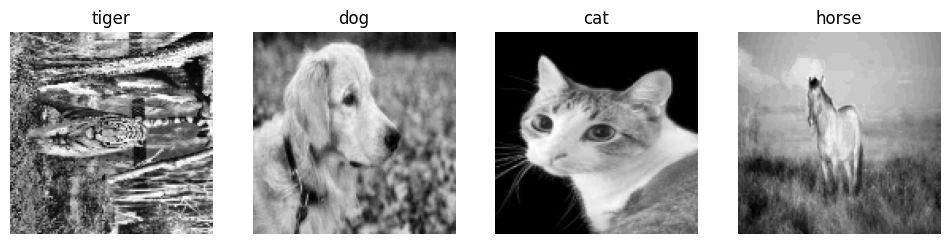

In [23]:
fig, axs = plt.subplots(1,4,figsize=(12,3));
for ax, sample in zip(axs.ravel(),train_loader):
    tensor, label = sample
    img = tensor2np(tensor)[0]
    label =  tensor2np(label)[0]
    ax.imshow(img[0], cmap='gray'); 
    ax.axis('off')
    ax.set_title(dataset.label2names[label])

In [24]:
##классы в наборе данных
dataset.class_names

{'panda': 0,
 'bear': 1,
 'lion': 2,
 'deer': 3,
 'tiger': 4,
 'bird': 5,
 'horse': 6,
 'dolphin': 7,
 'elephant': 8,
 'dog': 9,
 'zebra': 10,
 'giraffe': 11,
 'kangaroo': 12,
 'cat': 13}

In [25]:
class LeNet(nn.Module):
    def __init__(self, in_channels, n_classes):
        super().__init__()
        
        self.in_channels = in_channels
        self.n_classes   = n_classes
        
        # Convolution with stride 2
        self.conv1   = nn.Conv2d(in_channels  = self.in_channels, 
                                 out_channels = 6, 
                                 kernel_size  = 5,
                                 stride       = 2,
                                 padding      = 2,
                                 dilation     = 1)
        
        
        # Cascade Convolution
        conv2_1   = nn.Conv2d(in_channels     = 6, 
                                 out_channels = 16, 
                                 kernel_size  = 3,
                                 padding      = 1) 
        
        conv2_2   = nn.Conv2d(in_channels     = 16, 
                                 out_channels = 16, 
                                 kernel_size  = 3,
                                 padding      = 1) 
        
        self.conv2 = nn.Sequential(conv2_1, 
                                   nn.ReLU(),
                                   conv2_2,
                                   nn.BatchNorm2d(16))
        
        # Spatially-Separable Convolution
        conv3_1 = nn.Conv2d(in_channels  = 16, 
                            out_channels = 32, 
                            kernel_size  = (3,1),
                            padding      = 1)
        
        conv3_2 = nn.Conv2d(in_channels  = 32, 
                            out_channels = 32, 
                            kernel_size  = (1,3),
                            padding      = 1)
        
        self.conv3 = nn.Sequential(conv3_1, 
                                   nn.ReLU(),
                                   conv3_2)    

    
        # Residual bottleneck layer
        conv1x1_1 = nn.Conv2d(in_channels  = 32, 
                              out_channels = 16, 
                              kernel_size  = 1)
        
        conv3x3  = nn.Conv2d(in_channels  = 16, 
                             out_channels = 16, 
                             kernel_size  = 3,
                             padding      = 1)
        
        conv1x1_2 = nn.Conv2d(in_channels  = 16, 
                              out_channels = 32, 
                              kernel_size  = 1) 
        
        self.main_block = nn.Sequential(conv1x1_1,
                                        nn.BatchNorm2d(16),
                                        nn.ReLU(),
                                        conv3x3,
                                        nn.BatchNorm2d(16),
                                        nn.ReLU(),
                                        conv1x1_2,
                                        nn.BatchNorm2d(32))
        
        # Depthwise Separable Convolution
        depth_conv = nn.Conv2d(in_channels  = 32, 
                               out_channels = 64,  
                               kernel_size  = 3, 
                               groups       = 16,
                               padding      = 1)
        
        point_conv = nn.Conv2d(in_channels  = 64, 
                               out_channels = 128, 
                               kernel_size  = 1)
  
        self.conv5 = nn.Sequential(depth_conv, 
                                   nn.BatchNorm2d(64),
                                   nn.ReLU(),
                                   point_conv)
        
        
        #normalization
        self.bn1 = nn.BatchNorm2d(6)
        
        # pooling
        self.maxpool = nn.MaxPool2d(kernel_size = 2, 
                                    stride      = 2)
        
        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d((1,1))
        
        # classification
        self.fc_out = nn.Linear(in_features = 128, 
                                out_features = self.n_classes)

    
    def forward(self, x):
        
        # 1-st layer
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)        
        
        #2-nd layer
        x = self.conv2(x)         
        x = torch.relu(x)        
        x = self.maxpool(x)
        
        #3-nd layer
        x = self.conv3(x)         
        x = torch.relu(x)               
        x = self.maxpool(x)
        
        #4-th layer
        h = self.main_block(x)
        x = x+h
        x = torch.relu(x)

        #5-th layer
        x = self.conv5(x)         
        x = torch.relu(x) 

        # 1-st fc layer
        x = self.gap(x)
        h = torch.flatten(x, 1)
        x = self.fc_out(h)
        return x#torch.softmax(x, dim=1)

In [27]:
model = torchvision.models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')
model.fc = nn.Linear(512, 14)

In [28]:
# model = LeNet(3,14)

In [29]:
# def init_weights(m):
#     if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
#         nn.init.kaiming_normal_(m.weight)
#         m.bias.data.fill_(0)
        
# model.apply(init_weights);

In [30]:
def accuracy(y_pred, y):
    cls_pred = y_pred.argmax(1, keepdim=True)    
    correct_cls = cls_pred.eq(y.view_as(cls_pred)).sum()
    acc = correct_cls.float() / y.shape[0]
    return acc

In [32]:
LR = 0.003
device = 'cuda:0'
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
metric    = accuracy
model     = model.to(device)
criterion = criterion.to(device)

In [33]:
def train(model, dataloader, optimizer, criterion, metric,  device):

    epoch_loss = 0
    epoch_acc  = 0

    model.train()

    for (x, y) in tqdm(dataloader, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model.forward(x)

        loss = criterion(y_pred, y)
        acc  = metric( y_pred, y)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

In [34]:
def evaluate(model, dataloader, criterion, metric, device):

    epoch_loss = 0
    epoch_acc  = 0

    model.eval()

    with torch.no_grad():
        
        for (x, y) in tqdm(dataloader, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)
    
            y_pred = model.forward(x)

            loss = criterion(y_pred, y)
            acc  = metric( y_pred, y)

            epoch_loss += loss.item()
            epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [35]:
from tqdm.notebook import tqdm, trange
import time
EPOCHS = 30
train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc  = torch.zeros(EPOCHS)
valid_acc  = torch.zeros(EPOCHS)

best_valid_loss = float('inf')
best_epoch = 0

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()
    
    train_loss[epoch], train_acc[epoch] = train(model, 
                                                train_loader, 
                                                optimizer, 
                                                criterion, 
                                                metric,
                                                device)
    
    valid_loss[epoch], valid_acc[epoch] = evaluate(model, 
                                                   val_loader, 
                                                   criterion, 
                                                   metric,
                                                   device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(model.state_dict(), 'lenet_best_model.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    if epoch%2 == 1:    # print every 2 epochs:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch]*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch]*100:.2f}%')

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 2s
	Train Loss: 0.243 | Train Acc: 93.08%
	 Val. Loss: 0.390 |  Val. Acc: 87.78%


Training:   0%|          | 0/67 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 2s
	Train Loss: 0.009 | Train Acc: 100.00%
	 Val. Loss: 0.305 |  Val. Acc: 92.19%


Training:   0%|          | 0/67 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 2s
	Train Loss: 0.002 | Train Acc: 100.00%
	 Val. Loss: 0.297 |  Val. Acc: 92.71%


Training:   0%|          | 0/67 [00:00<?, ?it/s]

KeyboardInterrupt: 

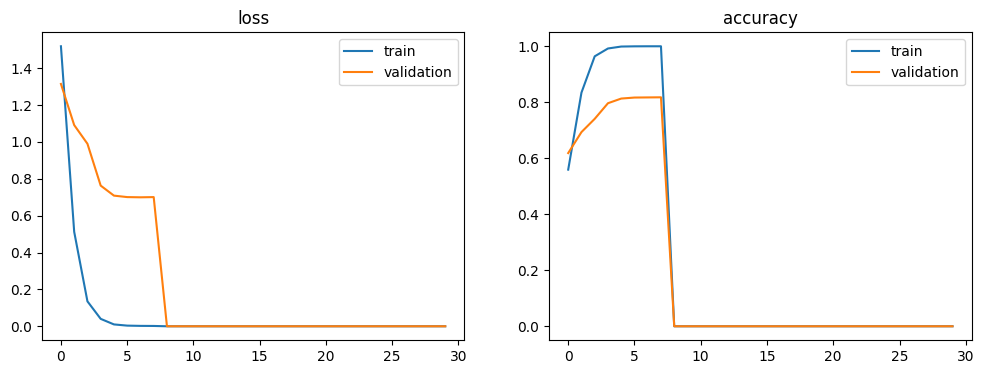

In [182]:
def plot_results(train_loss, valid_loss, train_acc, valid_acc ):
    fig,axs = plt.subplots(1,2,figsize = (12,4))
    axs[0].plot(train_loss.cpu().numpy(), label = 'train')
    axs[0].plot(valid_loss.cpu().numpy(), label = 'validation')
    axs[0].set_title('loss')
    axs[0].legend()
    axs[1].plot(train_acc.cpu().numpy(), label = 'train')
    axs[1].plot(valid_acc.cpu().numpy(), label = 'validation')

    axs[1].set_title('accuracy')
    axs[1].legend()
    plt.show()

plot_results(train_loss, valid_loss, train_acc, valid_acc )

In [36]:
n_classes = len(dataset.class_names)
n_samples = len(test_set)

class_correct = torch.zeros(n_classes)
class_total   = torch.zeros(n_classes)

labels   = []
predicts = []

names_classes = dataset.label2names
model.eval()

with torch.no_grad():
    
    for x,y in tqdm(val_loader):
        x = x.to(device)
        y = y.to('cpu')

        y_pred = model.forward(x).to('cpu')
        
        cls_pred = torch.argmax(y_pred, dim=1)
        
        c = (cls_pred == y).squeeze() # one-hot vector
        
        for i in range(x.shape[0]):
            label = y[i]
            class_correct[label] += c[i].item()
            class_total[label]   += 1
    
        labels.append(y)
        predicts.append(cls_pred)
        
labels   = torch.cat(labels, dim = 0) # make it 1d array
predicts = torch.cat(predicts, dim = 0) # make it 1d array
    
for i in range(n_classes):
    print('Accuracy of %5s : %2d %%' % (
        names_classes[i], 100 * class_correct[i] / class_total[i]))

  0%|          | 0/12 [00:00<?, ?it/s]

Accuracy of panda : 95 %
Accuracy of  bear : 91 %
Accuracy of  lion : 87 %
Accuracy of  deer : 100 %
Accuracy of tiger : 92 %
Accuracy of  bird : 85 %
Accuracy of horse : 100 %
Accuracy of dolphin : 100 %
Accuracy of elephant : 100 %
Accuracy of   dog : 87 %
Accuracy of zebra : 100 %
Accuracy of giraffe : 100 %
Accuracy of kangaroo : 100 %
Accuracy of   cat : 85 %


In [37]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
def plot_confusion_matrix(labels, pred_labels, names_classes):
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    cm = confusion_matrix(np.asarray(labels, dtype=int), 
                          np.asarray(pred_labels, dtype=int) )
    
    cm = ConfusionMatrixDisplay(cm, display_labels=names_classes)
    
    cm.plot(values_format='d', cmap='coolwarm', ax=ax)

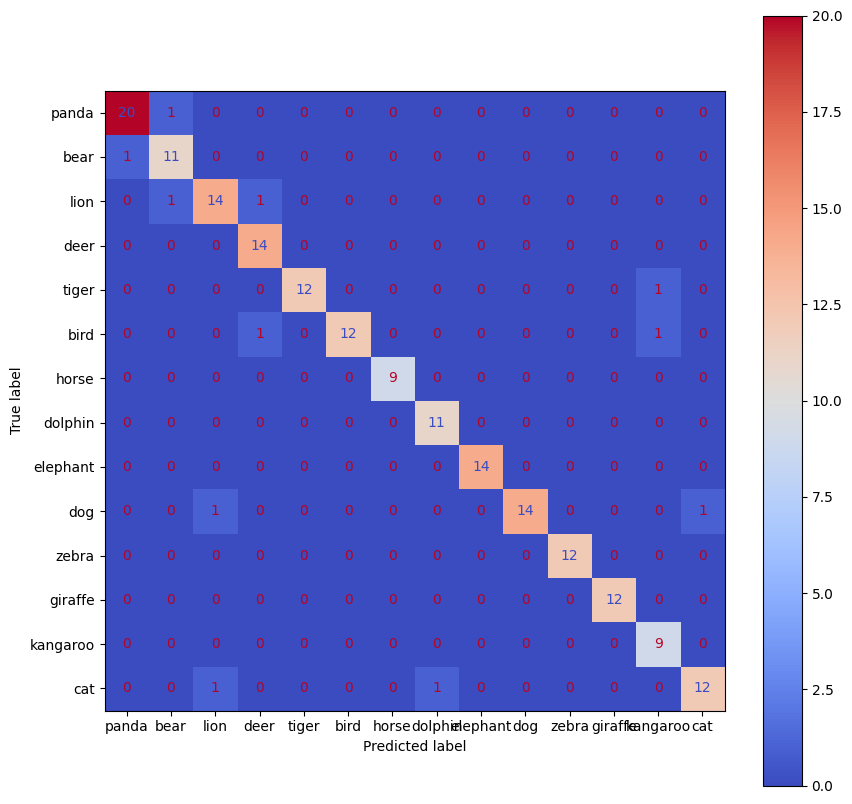

In [38]:
plot_confusion_matrix(labels, predicts, list(names_classes.values()))

In [91]:
path2test = Path('/storage/reshetnikov/URFU/Computer-Vision-Course_lec-practice/data/animals/test/')
ans = []
for f in path2test.rglob("*.jpg"):
    img = cv2.imread(str(f))
    img = train_transforms(img).to('cuda:0')
    # img.unsqueeze(0)
    y = model(img.unsqueeze(0))
    label = y.argmax(1).item()
    d = {"FILE_NAME": f.name, "TARGET":label:}
    ans.append(d)

In [92]:
pd.DataFrame(ans).to_csv('./submission.csv',index=False)

In [103]:
import pandas as pd
import shutil
path2test = Path('/storage/reshetnikov/URFU/Computer-Vision-Course_lec-practice/data/animals/test/')
ans = []
for e,f in enumerate(path2test.rglob("*.jpg")):
    name = f.name.split("_")[0]
    d = {"FILE_NAME": f"{e}.jpeg", "TARGET":dataset.class_names[name], "Usage":"Public"}
    ans.append(d)
    shutil.copy(f, f"/storage/reshetnikov/URFU/Computer-Vision-Course_lec-practice/data/animals/test_new/{e}.jpeg")
    
pd.DataFrame(ans).to_csv('../../data/animals/solution.csv',index=False)

In [141]:
frame= pd.DataFrame([dataset.class_names]).T

# frame.columns=columns
frame

,0
panda,0
bear,1
lion,2
deer,3
tiger,4
bird,5
horse,6
dolphin,7
elephant,8
dog,9


In [142]:
pd.DataFrame([dataset.class_names]).T.to_csv("../../data/animals/class_names.csv")

In [ ]:
!zip /storage/reshetnikov/URFU/Computer-Vision-Course_lec-practice/data/animals/train /storage/reshetnikov/URFU/Computer-Vision-Course_lec-practice/data/animals/